In [3]:
import requests
import pandas as pd
from datetime import datetime, timedelta
from tqdm import tqdm
import time

In [4]:
def get_TWSE_TWSE(self=None):
    '''
    url     : https://www.twse.com.tw/zh/indices/taiex/mi-5min-hist.html
    url_json: https://www.twse.com.tw/rwd/zh/TAIEX/MI_5MINS_HIST?date=20240701&response=json
    '''
    list_  = []
    for year in tqdm(range(2024, 2010, -1), desc='TWSE from 2024 to 2010'):
        limit_month = datetime.now().month if year == datetime.now().year else 13
        for month in range(1, limit_month):
            try:
                mo = f"0{month}" if month < 10 else month
                url_twse = f"https://www.twse.com.tw/rwd/zh/TAIEX/MI_5MINS_HIST?date={year}{mo}01&response=json"
                res = requests.get(url_twse)
                js = res.json()
                list_.append(js['data'])
            except KeyError:
                time.sleep(2)
                print("again for ", year , month)
                mo = f"0{month}" if month < 10 else month
                url_twse = f"https://www.twse.com.tw/rwd/zh/TAIEX/MI_5MINS_HIST?date={year}{mo}01&response=json"
                res = requests.get(url_twse)
                js = res.json()
                list_.append(js['data'])
    list_list = sum(list_, [])
    df = pd.DataFrame(list_list, columns=['da', 'open', 'high', 'low', 'close'])
    def convert_to_2024(da):
        year, month, day = da.split("/")
        return f"{int(year)+1911}-{month}-{day}"
    df['da'] = df['da'].apply(convert_to_2024)
    for i in range(1, len(df.columns)):
        df.iloc[:, i] = df.iloc[:, i].apply(lambda x: float(x.replace(",", "")))
    df.set_index("da", inplace=True)
    df.sort_index(ascending=True, inplace=True)
    df.to_parquet("TWSE.parquet")
    return df

df = get_TWSE_TWSE()

TWSE from 2024 to 2010: 100%|██████████| 14/14 [00:22<00:00,  1.62s/it]


In [29]:
def get_TWOTCI_TPEX(self=None):
    '''
    url     : https://www.tpex.org.tw/web/stock/iNdex_info/inxh/Inx.php?l=zh-tw
    url_json: https://www.tpex.org.tw/web/stock/iNdex_info/inxh/Inx_result.php?l=zh-tw&d=113/06/01
    '''
    list_  = []
    for year in tqdm(range(113, 102, -1), desc='TWOTCI from 113 to 103'):
        limit_month = datetime.now().month if year == datetime.now().year-1911 else 13
        for month in range(1, limit_month):
            try:
                mo = f"0{month}" if month < 10 else month
                url_twotci = f'https://www.tpex.org.tw/web/stock/iNdex_info/inxh/Inx_result.php?l=zh-tw&d={year}/{mo}/01'
                res = requests.get(url_twotci)
                js = res.json()
                list_.append(js['aaData'])
            except KeyError:
                time.sleep(2)
                print("again for ", year , month)
                mo = f"0{month}" if month < 10 else month
                url_twotci = f'https://www.tpex.org.tw/web/stock/iNdex_info/inxh/Inx_result.php?l=zh-tw&d={year}/{mo}/01'
                res = requests.get(url_twotci)
                js = res.json()
                list_.append(js['aaData'])

    list_list = sum(list_, [])
    df = pd.DataFrame(list_list, columns=['da', 'open', 'high', 'low', 'close', 'percentage'])
    def convert_to_2024(da):
        year, month, day = da.split("/")
        return f"{int(year)}-{month}-{day}"
    df['da'] = df['da'].apply(convert_to_2024)
    for i in range(1, len(df.columns)):
        df.iloc[:, i] = df.iloc[:, i].apply(lambda x: float(x.replace(",", "")))
    df.set_index("da", inplace=True)
    df.sort_index(ascending=True, inplace=True)
    df.to_parquet("TWOTCI.parquet")
    return df

df = get_TWOTCI_TPEX()


TWOTCI from 113 to 103: 100%|██████████| 11/11 [00:19<00:00,  1.80s/it]


In [108]:
twotci = pd.read_parquet("TWOTCI.parquet").iloc[:, :-1]
twotci['ticker'] = "TWOTCI"
twse = pd.read_parquet("TWSE.parquet")
twse['ticker'] = "TWSE"
df = pd.concat([twse, twotci], axis=0)

filtered_df = df.copy()
filtered_df['AvgPrice'] = (filtered_df['high'] + filtered_df['low']) / 2
filtered_df['Return'] = filtered_df.groupby('ticker')['AvgPrice'].pct_change()
filtered_df['beta'] = filtered_df.groupby('ticker')['close'].pct_change().shift(-1)
def rolling_std(group):
    group['return_stddev'] = group['Return'].rolling(window=5).std() * 100
    return group

filtered_df = filtered_df.groupby('ticker').apply(rolling_std).reset_index(level='ticker', drop=True)

def calculate_moving_averages(df):
    df['MA20'] = df['close'].rolling(window=20).mean()
    df['MA60'] = df['close'].rolling(window=60).mean()
    return df

filtered_df = filtered_df.groupby('ticker').apply(calculate_moving_averages).reset_index(level='ticker', drop=True)
start_date = '2015-01-01'
twse = filtered_df[(filtered_df['ticker'] == 'TWSE') & (filtered_df.index >= start_date)][['close', 'AvgPrice', "Return", "beta", "return_stddev", "MA20", "MA60"]]
twotci = filtered_df[(filtered_df['ticker'] == 'TWOTCI') & (filtered_df.index >= start_date)][['close', 'AvgPrice', "Return", "beta", "return_stddev", "MA20", "MA60"]]
twotci.reset_index(inplace=True)
twotci['da'] = pd.to_datetime(twotci['da'])
twse.reset_index(inplace=True)
twse['da'] = pd.to_datetime(twse['da'])

In [266]:
import numpy as np
def calculate_twotci_metrics(row):
    date = row['da']
    twotci_today = twotci[twotci['da'] == date]
    twotci_next = twotci[twotci['da'] > date].sort_values(by='da').head(1)

    if not twotci_today.empty and not twotci_next.empty:
        twotci_beta = twotci_next['close'].values[0] / twotci_today['close'].values[0] - 1
    else:
        twotci_beta = np.nan
    
    twotci_return_stddev = twotci[(twotci['da'] >= (pd.to_datetime(date) - pd.Timedelta(days=5))) & (twotci['da'] <= date)]['Return'].std() * 100
    twotci_ma20 = twotci[twotci['da'] <= date].sort_values(by='da', ascending=False).head(20)['close'].mean()
    twotci_ma60 = twotci[twotci['da'] <= date].sort_values(by='da', ascending=False).head(60)['close'].mean()
    twotci_cl = twotci_today['close'].values[0] if not twotci_today.empty else np.nan
    
    return pd.Series([twotci_beta, twotci_return_stddev, twotci_ma20, twotci_ma60, twotci_cl])

final_df = twse.copy()
final_df[['TWOTCI_BETA', 'TWOTCI_RETURN_STDDEV', 'TWOTCI_MA20', 'TWOTCI_MA60', 'TWOTCI_CL']] = final_df.apply(calculate_twotci_metrics, axis=1)


In [358]:
final_df.columns

Index(['da', 'close', 'AvgPrice', 'Return', 'beta', 'return_stddev', 'MA20',
       'MA60', 'TWOTCI_BETA', 'TWOTCI_RETURN_STDDEV', 'TWOTCI_MA20',
       'TWOTCI_MA60', 'TWOTCI_CL', 'pct_change', 'signal',
       'strategy_daily_return', 'cumprod', 'cumulative_strategy_return', 'MDD',
       'std_signal', 'TWOTCI_RETURN_STDDEV_PREV', 'ma_signal', 'final_signal',
       'daily_ret_final_signal', 'cumprod_final_signal', 'daily_ret_ma_signal',
       'cumprod_ma_signal', 'daily_ret_std_signal', 'cumprod_std_signal'],
      dtype='object')

In [406]:
final_df['pct_change'] = final_df['close'].pct_change().shift(-1)

def calculate_return_on_signal(row, signal_col='final_signal'):
    return row['pct_change'] if row[signal_col] == 1 else 0

final_df['return_stddev_prev'] = final_df['return_stddev'].shift(1)
final_df['final_signal'] = (final_df['TWOTCI_RETURN_STDDEV']/final_df['TWOTCI_RETURN_STDDEV_PREV'] < 3) & (final_df['MA20'] > final_df['MA60'])
final_df['daily_ret_final_signal'] = final_df.apply(calculate_return_on_signal, args=("final_signal",), axis=1)
final_df['cumprod_final_signal'] = (1+final_df['daily_ret_final_signal']).cumprod()

In [407]:
np.mean(final_df['TWOTCI_RETURN_STDDEV'])

0.68542448522579

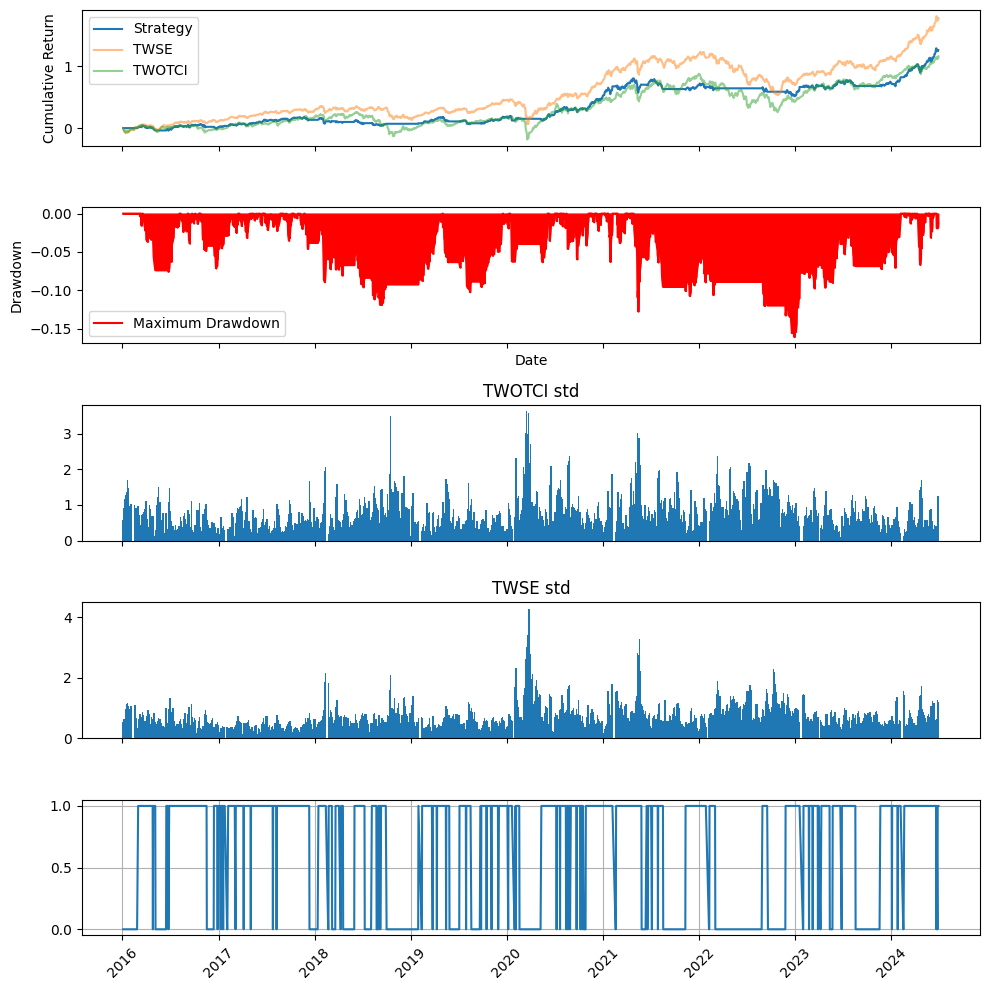

In [408]:

import matplotlib.pyplot as plt
fig, ax = plt.subplots(5, 1, figsize=(10, 10), sharex=True)
final_df = final_df[final_df['da'] >='2016-01-01']
ax[0].plot(final_df['da'], final_df['cumprod_final_signal']-1, label='Strategy')
ax[0].plot(final_df['da'], (1+final_df['Return']).cumprod()-1, label='TWSE', alpha=0.5)
ax[0].plot(final_df['da'], (1+final_df['TWOTCI_CL'].pct_change()).cumprod()-1, label='TWOTCI', alpha=0.5)
ax[0].set_ylabel('Cumulative Return')
ax[0].legend()

def from_nav_to_mdd(nav_all):
    Roll_Max = nav_all.rolling(len(nav_all), min_periods=1).max()
    Daily_Drawdown = nav_all/Roll_Max - 1.0
    return Daily_Drawdown
    
mdd = from_nav_to_mdd(final_df['cumprod_final_signal'])

ax[1].plot(final_df['da'],mdd, label='Maximum Drawdown', color='red')
ax[1].fill_between(final_df['da'], mdd, color='red')
ax[1].set_ylabel('Drawdown')
ax[1].set_xlabel('Date')
ax[1].legend()

ax[2].set_title("TWOTCI std")
ax[2].bar(final_df['da'], final_df['TWOTCI_RETURN_STDDEV'], width=5)
ax[3].set_title("TWSE std")
ax[3].bar(final_df['da'], final_df['return_stddev'], width=5)

ax[4].plot(final_df['da'], final_df['final_signal'])
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

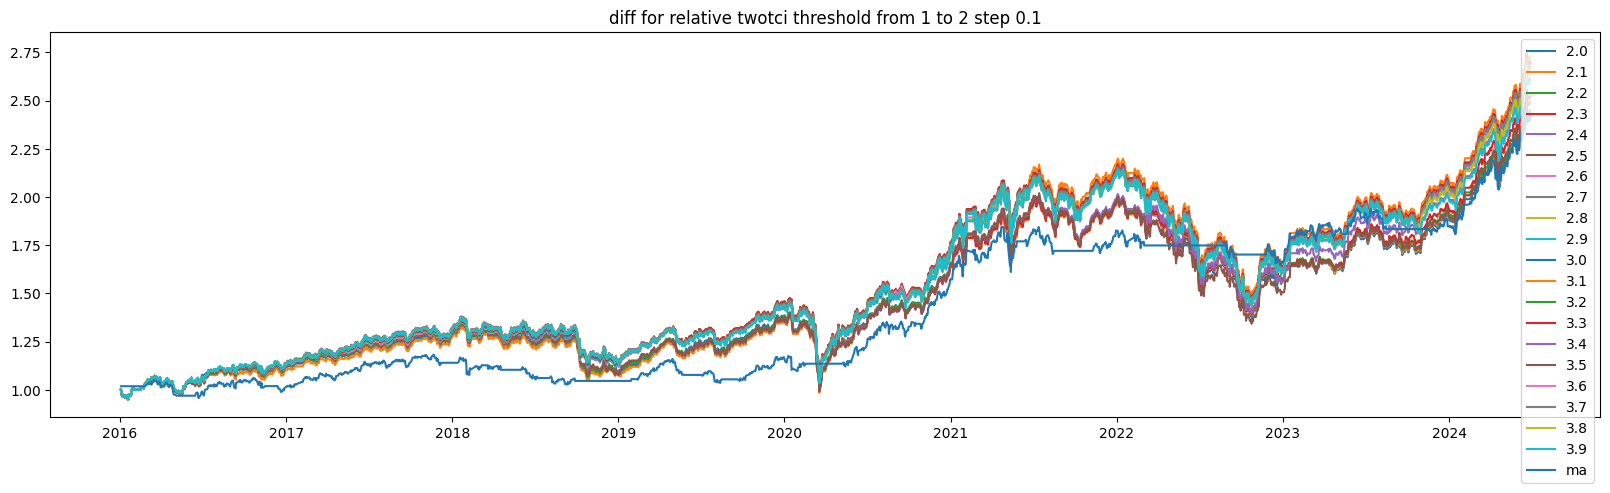

In [405]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(20, 5), sharex=True)
final = []
for threshold in range(20, 40):
    threshold/=10
    final_df['final_signal'] = (final_df['TWOTCI_RETURN_STDDEV']/final_df['TWOTCI_RETURN_STDDEV_PREV'] < threshold)
    final_df['daily_ret_final_signal'] = final_df.apply(calculate_return_on_signal, args=("final_signal",), axis=1)
    final_df['cumprod_final_signal'] = (1+final_df['daily_ret_final_signal']).cumprod()
    ax.plot(final_df['da'],final_df['cumprod_final_signal'], label=f"{threshold}")
    final.append(final_df['cumprod_final_signal'].iloc[-3])

ax.plot(final_df['da'], final_df['cumprod_ma_signal'], label='ma')
ax.legend()
ax.set_title('diff for relative twotci threshold from 1 to 2 step 0.1')
plt.show()